# GAN

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## The Data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
# Loading Mnist with one-hot encoded labels
mnist = input_data.read_data_sets("./data/MNIST_data/", one_hot = True)

Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


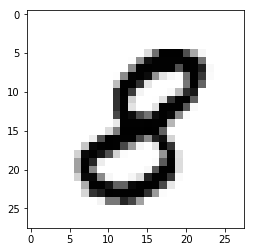

In [3]:
# Plotting the image
plt.imshow(mnist.train.images[5].reshape(28,28),
           cmap = 'Greys')

# The Networks

Useful Links:

https://stackoverflow.com/questions/45307072/using-leaky-relu-in-tensorflow

### Activation Function

## The Generator

In [4]:
# Creating a generator network
# The input is a distribution (here it is 100 points)
def generator(z, reuse = None):
    with tf.variable_scope('gen', reuse = reuse):
        hidden1 = tf.layers.dense(inputs = z,
                                  units = 128)
        # Simulating Leaky Relu
        # It will be added in Tensorflow
        alpha = 0.01
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        hidden2 = tf.layers.dense(inputs = hidden1,
                                  units = 128)
        
        hidden2 = tf.maximum(alpha * hidden2, hidden2)
        output = tf.layers.dense(hidden2,
                                 units = 784, 
                                 activation = tf.nn.tanh)
        return output
    

## The Discriminator

In [5]:
# Creating a discriminator network
def discriminator(X, reuse = None):
    with tf.variable_scope('dis', reuse = reuse):
        hidden1 = tf.layers.dense(inputs = X,
                                  units = 128)
        # Leaky Relu
        alpha = 0.01
        hidden1 = tf.maximum(alpha * hidden1,hidden1)
        
        hidden2 = tf.layers.dense(inputs = hidden1,
                                  units = 128)
        hidden2 = tf.maximum(alpha * hidden2, hidden2)
        
        logits = tf.layers.dense(hidden2,
                                 units = 1)
        output = tf.sigmoid(logits)
    
        return output, logits

### Placeholders

In [6]:
real_images = tf.placeholder(tf.float32,
                             shape = [None, 784])
z = tf.placeholder(tf.float32,
                   shape = [None, 100])

### Generator

In [7]:
G = generator(z)

### Discriminator 

In [8]:
D_output_real, D_logits_real = discriminator(real_images)

In [9]:
D_output_fake, D_logits_fake = discriminator(G, reuse = True)

### Losses

In [10]:
def loss_func(logits_in, labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits_in, 
                                                                  labels = labels_in))

In [11]:
# Encoding real values as ones with 0.9 smoothing
D_real_loss = loss_func(D_logits_real, tf.ones_like(D_logits_real) * (0.9))

In [12]:
# Encoding values as zeros
D_fake_loss = loss_func(D_logits_fake, tf.zeros_like(D_logits_real))

In [13]:
# Discriminator loss
D_loss = D_real_loss + D_fake_loss

In [14]:
# Generator loss -> how successful the generator is at fooling the discriminator 
G_loss = loss_func(D_logits_fake, tf.ones_like(D_logits_fake))

### Optimizers

In [15]:
learning_rate = 0.001

In [16]:
# All trainable variables
tvars = tf.trainable_variables()

# Gather all variables for the discriminator
d_vars = [var for var in tvars if 'dis' in var.name]
# Gather all variables for the generator
g_vars = [var for var in tvars if 'gen' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

['dis/dense/kernel:0', 'dis/dense/bias:0', 'dis/dense_1/kernel:0', 'dis/dense_1/bias:0', 'dis/dense_2/kernel:0', 'dis/dense_2/bias:0']
['gen/dense/kernel:0', 'gen/dense/bias:0', 'gen/dense_1/kernel:0', 'gen/dense_1/bias:0', 'gen/dense_2/kernel:0', 'gen/dense_2/bias:0']


In [17]:
D_trainer = tf.train.AdamOptimizer(learning_rate).minimize(D_loss, var_list = d_vars)
G_trainer = tf.train.AdamOptimizer(learning_rate).minimize(G_loss, var_list = g_vars)

## Training Session

In [18]:
batch_size = 100
epochs = 200
init = tf.global_variables_initializer()
saver = tf.train.Saver(var_list = g_vars)

In [19]:
# Save a sample per epoch
samples = []

In [20]:
with tf.Session() as sess:
    
    sess.run(init)
    
    # Recall an epoch is an entire run through the training data
    for e in range(epochs):
        # // indicates classic division
        num_batches = mnist.train.num_examples // batch_size
        
        for i in range(num_batches):
            
            # Grab batch of images
            batch = mnist.train.next_batch(batch_size)
            
            # Get images, reshape and rescale to pass to D
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images * 2 - 1
            
            # Z (random latent noise data for Generator)
            # -1 to 1 because of tanh activation
            batch_z = np.random.uniform(-1, 1, size = (batch_size, 100))
            
            # Run optimizers
            
            # Train the discriminator on the real images 
            # and the fake images generated by the generator with random latent noise z.
            _ = sess.run(D_trainer, feed_dict = {real_images: batch_images, 
                                               z: batch_z})
            # Train the generator
            _ = sess.run(G_trainer, feed_dict = {z: batch_z})
        
            
        print("Currently on Epoch {} of {} total...".format(e + 1, epochs))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size = (1, 100))
        gen_sample = sess.run(generator(z, 
                                        reuse = True),
                              feed_dict={z: sample_z})
        
        samples.append(gen_sample)
        
    saver.save(sess, './models/500_epoch_model.ckpt')

Currently on Epoch 1 of 200 total...
Currently on Epoch 2 of 200 total...
Currently on Epoch 3 of 200 total...
Currently on Epoch 4 of 200 total...
Currently on Epoch 5 of 200 total...
Currently on Epoch 6 of 200 total...
Currently on Epoch 7 of 200 total...
Currently on Epoch 8 of 200 total...
Currently on Epoch 9 of 200 total...
Currently on Epoch 10 of 200 total...
Currently on Epoch 11 of 200 total...
Currently on Epoch 12 of 200 total...
Currently on Epoch 13 of 200 total...
Currently on Epoch 14 of 200 total...
Currently on Epoch 15 of 200 total...
Currently on Epoch 16 of 200 total...
Currently on Epoch 17 of 200 total...
Currently on Epoch 18 of 200 total...
Currently on Epoch 19 of 200 total...
Currently on Epoch 20 of 200 total...
Currently on Epoch 21 of 200 total...
Currently on Epoch 22 of 200 total...
Currently on Epoch 23 of 200 total...
Currently on Epoch 24 of 200 total...
Currently on Epoch 25 of 200 total...
Currently on Epoch 26 of 200 total...
Currently on Epoch 27

In [21]:
saver = tf.train.Saver(var_list = g_vars)

new_samples = []
with tf.Session() as sess:
    
    saver.restore(sess,'./models/500_epoch_model.ckpt')
    
    for x in range(5):
        sample_z = np.random.uniform(-1, 1, 
                                     size = (1, 100))
        gen_sample = sess.run(generator(z,
                                        reuse = True),
                              feed_dict = {z: sample_z})
        
        new_samples.append(gen_sample)

INFO:tensorflow:Restoring parameters from ./models/500_epoch_model.ckpt


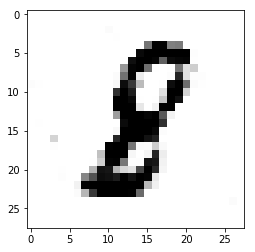

In [22]:
plt.imshow(new_samples[-1].reshape(28, 28),
           cmap = 'Greys')